# Many thanks to:

"laxmimerit/NLP-Tutorials-with-HuggingFace

AVP, Data Scientist @ IGP.COM | Lead Data Scientist @ KGPTalkie 50K+ YouTube Subscribers | Know more https://kgptalkie.com"

https://github.com/laxmimerit/NLP-Tutorials-with-HuggingFace

# **Fine-Tuning DistilBERT for Multi-Label Text Classification**
# (**Auto Tagging of Reaserch papers abstracts**)

In [1]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 20px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

## Installation

In [2]:
# install required packages
!pip install -U accelerate
!pip install -U transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 4.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

## Imports

In [3]:
# required libraries for Data Loading and Data pre-Processing
from datasets import load_dataset
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import nltk
import re
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import MultiLabelBinarizer

# required libraries for Data visulization
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

# required libararies for model building
from transformers import DistilBertTokenizer, AutoTokenizer

# DistilBertForSequenceClassification insted of ditilbertbaseduncased because it will automaticaly add a classification head on top of this masked language model but ditilbertbaseduncased work only for masked language modleing
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification #AutoModelForSequenceClassification also to provide classification head
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

# required libraries for Model Evaluatuion
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, hamming_loss
from transformers import EvalPrediction

# to save important object such as the multilabelbinarizaer object as a file
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Data**

## Data Loading

In [4]:
dataset = load_dataset("jamescalam/ai-arxiv", split='train')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/423 [00:00<?, ? examples/s]

## Data Exploration & Pre-Processing

In [5]:
# coverting dataset into a DataFrame for easier manipulation
dataset = pd.DataFrame(dataset)
dataset

,id,title,summary,source,authors,categories,comment,journal_ref,primary_category,published,updated,content,references
0,2210.03945,Understanding HTML with Large Language Models,Large language models (LLMs) have shown except...,http://arxiv.org/pdf/2210.03945,"[Izzeddin Gur, Ofir Nachum, Yingjie Miao, Must...","[cs.LG, cs.AI]",None,None,cs.LG,20221008,20230519,UNDERSTANDING HTML WITH LARGE LANGUAGE\nMODELS...,"[{'id': '2107.06955'}, {'id': '2204.02311'}, {..."
1,1711.05101,Decoupled Weight Decay Regularization,L$_2$ regularization and weight decay regulari...,http://arxiv.org/pdf/1711.05101,"[Ilya Loshchilov, Frank Hutter]","[cs.LG, cs.NE, math.OC]",Published as a conference paper at ICLR 2019,None,cs.LG,20171114,20190104,Published as a conference paper at ICLR 2019\n...,"[{'id': '1707.08819'}, {'id': '1705.08292'}, {..."
2,2305.17493,The Curse of Recursion: Training on Generated ...,Stable Diffusion revolutionised image creation...,http://arxiv.org/pdf/2305.17493,"[Ilia Shumailov, Zakhar Shumaylov, Yiren Zhao,...","[cs.LG, cs.AI, cs.CL, cs.CR, cs.CV]",None,None,cs.LG,20230527,20230531,THECURSE OF RECURSION :\nTRAINING ON GENERATED...,"[{'id': '1906.02243'}, {'id': '1810.04805'}, {..."
3,2205.09712,Selection-Inference: Exploiting Large Language...,Large language models (LLMs) have been shown t...,http://arxiv.org/pdf/2205.09712,"[Antonia Creswell, Murray Shanahan, Irina Higg...","[cs.AI, cs.CL]",None,None,cs.AI,20220519,20220519,2022-5-20\nSelection-Inference: Exploiting Lar...,"[{'id': '2205.09712'}, {'id': '2112.03753'}, {..."
4,2104.06001,Gender Bias in Machine Translation,Machine translation (MT) technology has facili...,http://arxiv.org/pdf/2104.06001,"[Beatrice Savoldi, Marco Gaido, Luisa Bentivog...",[cs.CL],Accepted for publication in Transaction of the...,None,cs.CL,20210413,20210507,Gender Bias in Machine Translation\nBeatrice S...,"[{'id': '2104.06001'}, {'id': '2012.15859'}, {..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,2204.06745,GPT-NeoX-20B: An Open-Source Autoregressive La...,"We introduce GPT-NeoX-20B, a 20 billion parame...",http://arxiv.org/pdf/2204.06745,"[Sid Black, Stella Biderman, Eric Hallahan, Qu...",[cs.CL],To appear in the Proceedings of the ACL Worksh...,None,cs.CL,20220414,20220414,GPT-NeoX-20B: An Open-Source Autoregressive La...,"[{'id': '1910.05895'}, {'id': '2110.06609'}, {..."
419,1707.06347,Proximal Policy Optimization Algorithms,We propose a new family of policy gradient met...,http://arxiv.org/pdf/1707.06347,"[John Schulman, Filip Wolski, Prafulla Dhariwa...",[cs.LG],None,None,cs.LG,20170720,20170828,Proximal Policy Optimization Algorithms\nJohn ...,"[{'id': '1604.06778'}, {'id': '1506.02438'}, {..."
420,2307.09288,Llama 2: Open Foundation and Fine-Tuned Chat M...,"In this work, we develop and release Llama 2, ...",http://arxiv.org/pdf/2307.09288,"[Hugo Touvron, Louis Martin, Kevin Stone, Pete...","[cs.CL, cs.AI]",None,None,cs.CL,20230718,20230719,L/l.sc/a.sc/m.sc/a.sc /two.taboldstyle : Open ...,"[{'id': '2302.13971'}, {'id': '1908.01091'}, {..."
421,2211.05100,BLOOM: A 176B-Parameter Open-Access Multilingu...,Large language models (LLMs) have been shown t...,http://arxiv.org/pdf/2211.05100,"[BigScience Workshop, :, Teven Le Scao, Angela...",[cs.CL],None,None,cs.CL,20221109,20230627,BLOOM: A 176B-Parameter Open-Access Multilingu...,"[{'id': '2208.07339'}, {'id': '2204.02311'}, {..."


In [6]:
dataset.shape

(423, 13)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                423 non-null    object
 1   title             423 non-null    object
 2   summary           423 non-null    object
 3   source            423 non-null    object
 4   authors           423 non-null    object
 5   categories        423 non-null    object
 6   comment           240 non-null    object
 7   journal_ref       14 non-null     object
 8   primary_category  423 non-null    object
 9   published         423 non-null    object
 10  updated           423 non-null    object
 11  content           423 non-null    object
 12  references        423 non-null    object
dtypes: object(13)
memory usage: 43.1+ KB


In [8]:
# drop columns that we do not need
df_dataset=dataset.drop(columns = ['id', 'title',  'source', 'authors',  'comment',
       'journal_ref', 'primary_category', 'published', 'updated', 'content',
       'references'])
df_dataset

,summary,categories
0,Large language models (LLMs) have shown except...,"[cs.LG, cs.AI]"
1,L$_2$ regularization and weight decay regulari...,"[cs.LG, cs.NE, math.OC]"
2,Stable Diffusion revolutionised image creation...,"[cs.LG, cs.AI, cs.CL, cs.CR, cs.CV]"
3,Large language models (LLMs) have been shown t...,"[cs.AI, cs.CL]"
4,Machine translation (MT) technology has facili...,[cs.CL]
...,...,...
418,"We introduce GPT-NeoX-20B, a 20 billion parame...",[cs.CL]
419,We propose a new family of policy gradient met...,[cs.LG]
420,"In this work, we develop and release Llama 2, ...","[cs.CL, cs.AI]"
421,Large language models (LLMs) have been shown t...,[cs.CL]


In [9]:
# Summary Pre-processing

def preprocess_text(text):
    # convert text to lower case
    text = text.lower()
    # split text into tokens to remove whitespaces
    words = word_tokenize(text)
    # Remove special characters and punctuation using regular expression
    words = [re.sub(r'[^a-zA-Z]', '', word) for word in words]  # Removes numbers and special characters

    return " ".join(words)

df_dataset['summary'] = df_dataset['summary'].apply(preprocess_text)
df_dataset['summary'][1]

'l    regularization and weight decay regularization are equivalent for standard stochastic gradient descent  when rescaled by the learning rate   but as we demonstrate this is emph  not  the case for adaptive gradient algorithms  such as adam  while common implementations of these algorithms employ l    regularization  often calling it  weight decay  in what may be misleading due to the inequivalence we expose   we propose a simple modification to recover the original formulation of weight decay regularization by emph  decoupling  the weight decay from the optimization steps taken wrt  the loss function  we provide empirical evidence that our proposed modification  i  decouples the optimal choice of weight decay factor from the setting of the learning rate for both standard sgd and adam and  ii  substantially improves adams generalization performance  allowing it to compete with sgd with momentum on image classification datasets  on which it was previously typically outperformed by th

In [10]:
# Check data types of values in the 'categories' column (one of the Data Challenges that have been solved and this is a check to see if the problem still existe or not (problem of NaN type of 'categories' column))

print(df_dataset['categories'].dtype)
types = df_dataset['categories'].apply(type)
types.value_counts()#to check if all the categoris of the same type and if it has NaN values or not for later processing(converting categories into a a binary representation)

object


categories
<class 'list'>    423
Name: count, dtype: int64

In [11]:
df_dataset

,summary,categories
0,large language models llms have shown except...,"[cs.LG, cs.AI]"
1,l regularization and weight decay regulariz...,"[cs.LG, cs.NE, math.OC]"
2,stable diffusion revolutionised image creation...,"[cs.LG, cs.AI, cs.CL, cs.CR, cs.CV]"
3,large language models llms have been shown t...,"[cs.AI, cs.CL]"
4,machine translation mt technology has facili...,[cs.CL]
...,...,...
418,we introduce gptneoxb a billion parameter au...,[cs.CL]
419,we propose a new family of policy gradient met...,[cs.LG]
420,in this work we develop and release llama a...,"[cs.CL, cs.AI]"
421,large language models llms have been shown t...,[cs.CL]


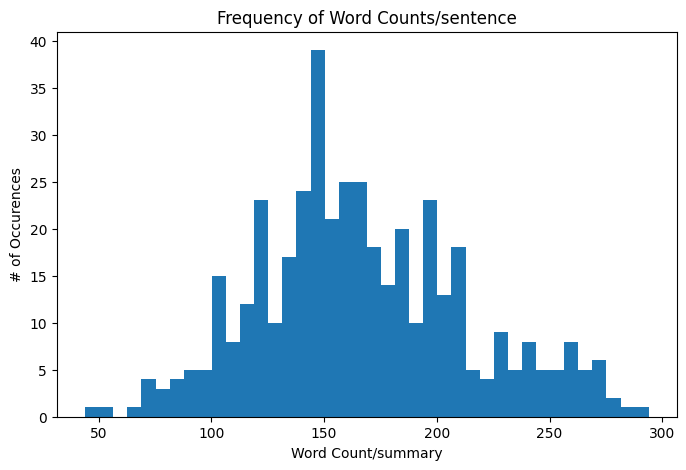

In [12]:
# compute no. of words in each summary to investegate the need of token turncation
# DistilBERT max leangth is 512 token so max length of summaries in dataset should be <= DistilBert max token leangth

summary = df_dataset['summary']
word_cnt = [len(summ.split()) for summ in summary]
# Plot the distribution
plt.figure(figsize=[8,5])
plt.hist(word_cnt, bins = 40)
plt.xlabel('Word Count/summary')
plt.ylabel('# of Occurences')
plt.title("Frequency of Word Counts/sentence")
plt.show()

In [13]:
# category investegation
categories_counts = [c for cat in df_dataset['categories'] for c in cat]
# count frequency of each single category
pd.Series(categories_counts).value_counts()
#there is a bias in data in which the model will tend to pridict the most frequent categories more often than the rest
#data contains impalenced class labels which might affect preformance(for later investgtion)

cs.CL                            314
cs.LG                            203
cs.AI                            161
stat.ML                           54
cs.CY                             35
cs.CV                             32
cs.NE                             10
cs.CR                             10
cs.RO                              8
cs.IR                              5
cs.SE                              5
cs.HC                              4
cs.SI                              4
I.2.7                              4
cs.PL                              3
eess.AS                            2
cs.SD                              2
cs.MA                              2
q-bio.NC                           2
I.2.6; I.2.7                       2
math.OC                            2
cs.AR                              2
68T50, 68T09, 91D30                1
cs.PF                              1
q-fin.EC                           1
econ.GN                            1
I.2; I.2.7                         1
6

## Label Encoder

In [14]:
# Encode the categories(labels) in a float format in order to be used for training & inference
multilabel = MultiLabelBinarizer()

labels = multilabel.fit_transform(df_dataset['categories']).astype('float32')

texts = df_dataset['summary'].tolist()

In [15]:
labels.shape # 48 is the number of unique labels

(423, 48)

In [16]:
# To check the result of encoding
print("categories of first summary: ",df_dataset['categories'][0])
print("one-hot encoding of categories of first summary: ",labels[0])
print(multilabel.inverse_transform(labels[0].reshape(1,-1)))
print(multilabel.classes_[28])

categories of first summary:  ['cs.LG', 'cs.AI']
one-hot encoding of categories of first summary:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[('cs.AI', 'cs.LG')]
cs.LG


In [17]:
texts[:5]

['large language models  llms  have shown exceptional performance on a variety of natural language tasks  yet  their capabilities for html understanding  ie  parsing the raw html of a webpage  with applications to automation of webbased tasks  crawling  and browserassisted retrieval  have not been fully explored  we contribute html understanding models  finetuned llms  and an indepth analysis of their capabilities under three tasks   i  semantic classification of html elements   ii  description generation for html inputs  and  iii  autonomous web navigation of html pages  while previous work has developed dedicated architectures and training procedures for html understanding  we show that llms pretrained on standard natural language corpora transfer remarkably well to html understanding tasks  for instance  finetuned llms are   more accurate at semantic classification compared to models trained exclusively on the task dataset  moreover  when finetuned on data from the miniwob benchmark

## Data Split

In [18]:
# Split data into training and testing sets with a ratio of (90% train, 10% test) because we have very small data so we need higher train split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.10, random_state=42)

# Further split the training set into training and validation sets (split ratio 90%, 10% validation) so we can have a data split ratio of (80, 10, 10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

# **Model Building**

In [ ]:
#load the model and tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels[0]), problem_type="multi_label_classification")

# This model has a classification head with the number of output neurons equal to the number of labels(e.g.len(labels[0])).
# These neurons have a softmax activation function, and they are responsible for predicting the probability of each label.

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model Input Preparation

In [ ]:
# to process our data and transform custom dataset into a torch tensor to be fed into the model
class CustomDataset(Dataset): # Dataset is a torch class -> super abstract class that gets inhereted by CustomDataset class

    def __init__(self, texts, labels, tokenizer, max_len=300):
      #max_len=128 as standard, the model is trained on a max sequece length of 512 or less due to computational constraints,
      #value of max_len could impact training efficiency; shorter sequences can lead to faster training and require fewer computations compared to longer sequences
      #data distribution:
      self.texts = texts
      self.labels = labels
      self.tokenizer = tokenizer
      self.max_len = max_len

    def __len__(self):
      return len(self.texts)

      #tokenization will happen here , this method will allow us to access individual samples when iterating over it using 'idx'
    def __getitem__(self, idx): #idx = index while iterating the dataset
       text = str(self.texts[idx]) #convert the text to a string to ensure compatibility with the tokenizer
       label = torch.tensor(self.labels[idx]) #convert the label to a pytorch tensor
       encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length = self.max_len, return_tensors='pt')
# truncation=True -> if text exceeds max_len=300, then truncate it.
# padding="max_length" -> pads the exceeded sequence to the length of max_length =300
# max_length = self.max_len -> specifies the maximum length allowed of the tokenized text
# return_tensors='pt' -> returns the tokenized text as pytorch tensor.
# encoding -> dictionary containing the tokenized input, including 'input_ids' and 'attention_mask'

       return {
           'input_ids': encoding['input_ids'].flatten(),
           'attention_mask': encoding['attention_mask'].flatten(),
           'labels': label
       }
# the last segment returns the dictionary along with the correspoinding label, The flatten() method is used to convert the
#tensors into one-dimensional tensors; to ensure compatibility with the neural network, as they expect input to  be a 1-D tensor. and to reduces memory overhead

In [ ]:
train_dataset = CustomDataset(X_train, y_train, tokenizer)
validat_dataset = CustomDataset(X_val, y_val, tokenizer)
test_dataset = CustomDataset(X_test, y_test, tokenizer)

In [ ]:
train_dataset[0]

{'input_ids': tensor([  101,  2023,  5002,  4391,  2573,  1999,  2029,  2653,  4275,  1048,
          5244,  2024, 19335,  2007, 13384,  4813,  1998,  1996,  3754,  2000,
          2224,  5906,  1996,  2280,  2003,  4225,  2004, 21933,  8737, 18606,
          1037,  9280,  3375,  4708,  2046, 16325,  4942, 10230,  5705,  2096,
          1996,  3732,  3774,  1999,  4214,  6327, 14184,  2107,  2004,  1037,
          3642, 19555,  1048,  5244,  2064, 21155,  2122, 15476,  3672, 10708,
         10329,  2030,  1999,  5257,  3081,  2002,  9496, 10074,  2015,  2030,
          4553,  2000,  2079,  2061,  2013, 13616,  2096,  4748, 22658,  2000,
          1037,  3115,  4394, 19204,  2015, 17547,  7863,  2107, 19335,  1048,
          5244,  2064,  2224,  2536,  4298,  2512, 28689, 12589,  6327, 14184,
          2000,  7818,  2037,  6123,  6364,  3754,  2947, 15971,  2013,  1996,
          5760,  2653, 11643, 20680,  2057,  3568,  6523,  2000,  2068,  2004,
         19335,  2653,  4275,  2632,  5

In [ ]:
validat_dataset[0]

{'input_ids': tensor([  101,  2312,  2653,  4275,  2031,  2042,  3491,  2000,  6162,  9487,
          2836,  2408,  1037,  3528,  1997,  3019,  2653,  8518,  2478,  2261,
         19040,  4083,  2029, 21040, 13416,  1996,  2193,  1997,  8518,  5051,
          6895,  8873,  2278,  2731,  4973,  2734,  2000, 15581,  1996,  2944,
          2000,  1037,  3327,  4646,  2000,  2582,  2256,  4824,  1997,  1996,
          4254,  1997,  4094,  2006,  2261, 19040,  4083,  2057,  4738,  1037,
          4551, 16381, 19441,  8878, 10938,  2121,  2653,  2944,  2029,  2057,
          2655, 16910,  2653,  2944,  5340,  2057,  4738,  5340,  2006,  1056,
         14289,  1058, 11772,  2478, 16910,  1037,  2047, 19875,  2291,  2029,
         12939,  3811,  8114,  2731,  2408,  3674,  1056, 14289, 26723,  2057,
         10580,  2506,  6666,  1997, 25169,  2011, 10910,  2110, 15794, 22375,
          2261, 19040,  4083,  3463,  2006,  5606,  1997,  2653,  4824,  1998,
          4245,  6847, 27373,  2006,  1

In [ ]:
test_dataset[0]

{'input_ids': tensor([  101,  1996,  2434,  3746,  7159,  2951, 13462,  2003,  1037,  2759,
          2312, 15782,  2571,  6847, 10665,  2005,  2731,  2784, 15756,  6125,
          2144,  1996,  3465,  1997,  4488,  7885,  1041,  2290,  9896,  2640,
          4294,  3945,  1998, 23760, 28689, 22828, 17372,  2006,  1996,  2434,
          2951, 13462,  2453,  2022, 23469,  3512,  2057, 16599,  2000,  5136,
          1037, 12482, 16613,  3709,  2544,  1997,  3746,  7159,  1999,  5688,
          2000,  1996, 25022, 14971,  2951, 13462,  2015,  1998,  3041, 12482,
         16613,  3709,  4617,  1997,  3746,  7159,  2256,  3818,  3746,  7159,
          2335,  1998,  2049, 10176,  3746,  7159,  2335,  1998,  3746,  7159,
          2335,  3397,  3599,  1996,  2168,  2193,  1997,  4280,  1998,  4871,
          2004,  3746,  7159,  2007,  1996,  2069,  4489,  2008,  1996,  4871,
          2024, 12482, 16613,  3709,  2000,  2335, 27725,  2566,  3746,  2335,
          1998,  2335, 27725,  2005,  1

## Model Evaluation Methods


*   Precision: the ratio of correctly predicted positive observations to the total predicted positives.
*   Recall: the ratio of correctly predicted positive observations to the all observations in actual class.
*   accuracy: the ratio of correctly predicted observations to the total observations.
*   F1-score: the weighted average of precision and recall.
*   Hamming loss: the fraction of labels that are incorrectly predicted.








In [ ]:
def multi_labels_metrics(predictions, labels, threshold=0.3):
    # creating an instance of the sigmoid activation function from the PyTorch library.
    sigmoid = torch.nn.Sigmoid()
    # convert the predicted scores (resulted from output layer of the model) into probabilities using the sigmoid function
    probs = sigmoid(torch.Tensor(predictions))
    # convert the probabilities into binary predictions based on the specified threshold.
    y_pred = np.zeros(probs.shape)
    y_pred[probs >= threshold] = 1
    y_true = labels


    # Calculate evaluation metrics
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    Accuracy = accuracy_score(y_true, y_pred, normalize=False)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    hamming = hamming_loss(y_true, y_pred)

    # average='weighted' -> Specifies the averaging method to compute precision.'weighted' takes the weighted average of the specefied metric (Precision, Recall, F1) across different classes, weighted by the number of true instances in each class.
    # zero_division=0 -> Specifies the action to take when a class with no true samples is encountered. Setting it to 0 ensures that if there are no true instances for a class, the metric for that class is considered as 0.
    # normalize=False -> Count of correctly classified samples.
    metrics = {
        "hamming_loss": hamming,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "accuracy": Accuracy,
    }

    return metrics


In [ ]:
# Override compute_metrics method from transformers class (EvalPrediction)
def compute_metrics(p:EvalPrediction):
       preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions #to check if the predctions are stored in a tuple format, we are giong to take the first predction otherwayes it will select the precdtions directly

       result = multi_labels_metrics(predictions=preds,labels=p.label_ids)

       return result

## Model Training
training args:

-per_device_train_batch_size -> Specifies the batch size of training data per device (such as GPU) during training.

-per_device_eval_batch_size -> Specifies the batch size of evaluation data per device during evaluation.

-output_dir -> Specifies the directory where the fine-tuned model and associated files will be saved.

-num_train_epochs -> Specifies the number of epochs (complete passes through the training data) for training the model.

-weight_decay -> Specifies the weight decay (L2 regularization) coefficient for controlling overfitting during training.

-evaluation_strategy -> Specifies the strategy for evaluation during training. In this case, it's set to "steps", indicating that evaluation will be performed at fixed intervals defined by logging_steps.

-logging_steps -> Specifies the frequency of logging training metrics and evaluation results during training.

-lr_scheduler_type -> Specifies the type of learning rate scheduler used during training.

-warmup_steps -> Specifies the number of warm-up steps for the learning rate scheduler.

-learning_rate -> Sets the learning rate used by the optimizer during training. Here, the learning rate is set to 2e-05, which is a commonly used value for fine-tuning transformer-based models like DistilBERT for natural language processing tasks.

-disable_tqdm -> Specifies whether to disable the progress bar (tqdm) during training and evaluation.

-log_level -> Specifies the level of logging details. Here, it's set to "error", indicating that only error messages will be logged.

-load_best_model_at_end -> Specifies whether to load the best model based on evaluation results at the end of training.



In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    per_device_train_batch_size=20,
    per_device_eval_batch_size=20,
    output_dir = './finetunedDistilBERT',
    learning_rate=2e-05,
    seed=42,
    num_train_epochs=15,
    weight_decay=0.01,
    evaluation_strategy="steps",
    logging_steps=100,
    lr_scheduler_type="linear",
    warmup_steps=500,
    disable_tqdm=False,
    log_level="error",
    load_best_model_at_end=True
)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset = train_dataset,
                  eval_dataset = validat_dataset,
                  compute_metrics = compute_metrics)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Hamming Loss,F1,Precision,Recall,Accuracy,Runtime,Samples Per Second,Steps Per Second
100,0.076000,0.085669,0.033443,0.581001,0.498634,0.707317,4,0.505800,75.124000,3.954000


TrainOutput(global_step=165, training_loss=0.0740394707882043, metrics={'train_runtime': 153.4258, 'train_samples_per_second': 33.436, 'train_steps_per_second': 1.075, 'total_flos': 398505015648000.0, 'train_loss': 0.0740394707882043, 'epoch': 15.0})

## Model Validation

In [ ]:
trainer.evaluate(validat_dataset)

{'eval_loss': 0.08402183651924133,
 'eval_hamming_loss': 0.03289473684210526,
 'eval_f1': 0.5863920696092281,
 'eval_precision': 0.5082262367326434,
 'eval_recall': 0.7073170731707317,
 'eval_accuracy': 4,
 'eval_runtime': 0.559,
 'eval_samples_per_second': 67.982,
 'eval_steps_per_second': 3.578,
 'epoch': 15.0}

## Model Evaluation / Preformance Evaluation

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.06783310323953629,
 'eval_hamming_loss': 0.027131782945736434,
 'eval_f1': 0.6611561498269795,
 'eval_precision': 0.5960357152307617,
 'eval_recall': 0.7472527472527473,
 'eval_accuracy': 9,
 'eval_runtime': 0.7619,
 'eval_samples_per_second': 56.439,
 'eval_steps_per_second': 2.625,
 'epoch': 15.0}

## Model Saving

In [ ]:
# save the fine-tuned model
trainer.save_model("distilbert-finetuned-arxiv-multi-label")

In [ ]:
# save the model tokenizer
tokenizer.save_pretrained("distilbert-finetuned-arxiv-multi-label/tokenizer")

('distilbert-finetuned-arxiv-multi-label/tokenizer/tokenizer_config.json',
 'distilbert-finetuned-arxiv-multi-label/tokenizer/special_tokens_map.json',
 'distilbert-finetuned-arxiv-multi-label/tokenizer/vocab.txt',
 'distilbert-finetuned-arxiv-multi-label/tokenizer/added_tokens.json')

In [ ]:
# save the multilabelbinarizer object for later use at model inference
with open("multi-label-binarizer.pkl", "wb") as f:
  pickle.dump(multilabel, f)

In [ ]:
# save the model files as a zip file for easier download
!zip -r distilbert.zip "/content/distilbert-finetuned-arxiv-multi-label"

  adding: content/distilbert-finetuned-arxiv-multi-label/ (stored 0%)
  adding: content/distilbert-finetuned-arxiv-multi-label/model.safetensors (deflated 8%)
  adding: content/distilbert-finetuned-arxiv-multi-label/tokenizer/ (stored 0%)
  adding: content/distilbert-finetuned-arxiv-multi-label/tokenizer/tokenizer_config.json (deflated 74%)
  adding: content/distilbert-finetuned-arxiv-multi-label/tokenizer/special_tokens_map.json (deflated 42%)
  adding: content/distilbert-finetuned-arxiv-multi-label/tokenizer/vocab.txt (deflated 53%)
  adding: content/distilbert-finetuned-arxiv-multi-label/config.json (deflated 69%)
  adding: content/distilbert-finetuned-arxiv-multi-label/training_args.bin (deflated 51%)


## Model Prediction

In [ ]:
text = "A recently developed language representation model named Bidirectional Encoder Representation from Transformers (BERT) is based on an advanced trained deep learning approach that has achieved excellent results in many complex tasks, the same as classification, Natural Language Processing (NLP), prediction, etc. This survey paper mainly adopts the summary of BERT, its multiple types,  and  its  latest  developments  and  applications  in various  computer  science  and  engineering  fields. Furthermore,  it  puts  forward  BERT's  problems  and attractive future research trends in a different area with multiple datasets.  From the findings, overall, the BERT and their recent types have achieved more accurate, fast, and  optimal results  in  solving  most complex  problems than typical Machine and Deep Learning methods."
encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [ ]:
# further output interpretation for clear representation of model prediction
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1

multilabel.inverse_transform(preds.reshape(1,-1))

[('cs.AI', 'cs.CL', 'cs.LG')]